# Getting Started with MiniMax M2.1
To get started with MiniMax M2.1, you’ll need an API key from the MiniMax platform. You can generate one from the [MiniMax user console](https://platform.minimax.io/user-center/basic-information/interface-key).

Once issued, store the API key securely and avoid exposing it in code repositories or public environments.


## Installing & Setting up the dependencies
MiniMax supports both the Anthropic and OpenAI API formats, making it easy to integrate MiniMax models into existing workflows with minimal configuration changes—whether you’re using Anthropic-style message APIs or OpenAI-compatible setups.

In [3]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 13.1 MB/s eta 0:00:00


In [1]:
import os
from getpass import getpass
os.environ['ANTHROPIC_BASE_URL'] = 'https://api.minimax.io/anthropic'
os.environ['ANTHROPIC_API_KEY'] = getpass('Enter MiniMax API Key: ')

Enter MiniMax API Key: ··········


With just this minimal setup, you’re ready to start using the model.

## Sending Requests to the Model
MiniMax M2.1 returns structured outputs that separate internal reasoning (thinking) from the final response (text). This allows you to observe how the model interprets intent and plans its answer before producing the user-facing output.


In [3]:
import anthropic

client = anthropic.Anthropic()

message = client.messages.create(
    model="MiniMax-M2.1",
    max_tokens=1000,
    system="You are a helpful assistant.",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Hi, how are you?"
                }
            ]
        }
    ]
)

for block in message.content:
    if block.type == "thinking":
        print(f"Thinking:\n{block.thinking}\n")
    elif block.type == "text":
        print(f"Text:\n{block.text}\n")

Thinking:
The user is just asking how I am doing. This is a friendly greeting, so I should respond in a warm, conversational way. I'll keep it simple and friendly.

Text:
Hi! I'm doing well, thanks for asking! 😊

I'm ready to help you with whatever you need today. Whether it's coding, answering questions, brainstorming ideas, or just chatting, I'm here for you.

What can I help you with?



What makes MiniMax stand out is the visibility into its reasoning process. Before producing the final response, the model explicitly reasons about the user’s intent, tone, and expected style—ensuring the answer is appropriate and context-aware.

This clear separation between thinking and response makes the model’s behavior easier to understand, debug, and trust, especially in agent-driven or multi-step workflows where reasoning quality matters as much as the final output.


# What's New?
One of the standout features of MiniMax M2 is its native mastery of Interleaved Thinking—a reasoning approach that allows the model to plan, execute, and adapt its logic seamlessly during complex code and tool-based workflows. M2.1 builds on this foundation, introducing tangible improvements such as better code quality, smarter instruction following, cleaner reasoning, and stronger performance across multiple programming languages.

To evaluate these capabilities in practice, let’s test the model using a structured coding prompt that includes multiple constraints and real-world engineering requirements.


This test uses a deliberately structured and constraint-heavy prompt designed to evaluate more than just code generation. The prompt requires strict input validation, in-memory state management, thread safety, testability, and extensibility—all without relying on external libraries.

By combining architectural decisions with multiple non-trivial constraints, the prompt operates at a medium-to-high complexity level, making it well-suited for assessing how effectively MiniMax M2.1 follows instructions, reasons through design trade-offs, and produces production-quality code rather than isolated snippets.


In [100]:
import anthropic

client = anthropic.Anthropic()

def run_test(prompt: str, title: str):
    print(f"\n{'='*80}")
    print(f"TEST: {title}")
    print(f"{'='*80}\n")

    message = client.messages.create(
        model="MiniMax-M2.1",
        max_tokens=10000,
        system=(
            "You are a senior software engineer. "
            "Write production-quality code with clear structure, "
            "explicit assumptions, and minimal but sufficient reasoning. "
            "Avoid unnecessary verbosity."
        ),
        messages=[
            {
                "role": "user",
                "content": [{"type": "text", "text": prompt}]
            }
        ]
    )

    for block in message.content:
        if block.type == "thinking":
            print("🧠 Thinking:\n", block.thinking, "\n")
        elif block.type == "text":
            print("📄 Output:\n", block.text, "\n")



In [90]:
PROMPT= """
Design a small Python service that processes user events.

Requirements:
1. Events arrive as dictionaries with keys: user_id, event_type, timestamp.
2. Validate input strictly (types + required keys).
3. Aggregate events per user in memory.
4. Expose two functions:
   - ingest_event(event: dict) -> None
   - get_user_summary(user_id: str) -> dict
5. Code must be:
   - Testable
   - Thread-safe
   - Easily extensible for new event types
6. Do NOT use external libraries.

Provide:
- Code only
- Brief inline comments where needed
"""

run_test(prompt=PROMPT, title="Instruction Following + Architecture")


TEST: Instruction Following + Architecture

🧠 Thinking:
 We are going to design a class `EventProcessor` that holds an in-memory dictionary for each user.
 Since we require thread safety, we will use a `threading.Lock` for operations that modify the state.
 We'll validate the input in `ingest_event` by checking the presence and types of the required keys.
 We'll aggregate events per user. For simplicity, we can store a list of events per user and then compute the summary on demand.
 However, the requirement says "aggregate events", so we might want to precompute some summaries? 
 But note: the requirement only says to expose two functions: `ingest_event` and `get_user_summary`.
 The `get_user_summary` returns a dictionary. We are free to design the structure of the summary.

 Let's assume we want to return:
   - a list of events (maybe sorted by timestamp?) 
   - or a summary per event type (count of each event type)?

 Since the requirement doesn't specify, let's design the summary t

The model reasons through key architectural trade-offs before coding, carefully balancing flexibility, memory usage, and extensibility. It evaluates multiple approaches to event aggregation and deliberately chooses raw event storage to enable future extensions without modifying ingestion logic.

Thread safety is explicitly handled through locking, and strict input validation is planned to ensure data correctness, reflecting a real-world, engineering-first mindset rather than jumping straight to implementation.

This thoughtful reasoning is reflected in the final output, which demonstrates strong code quality through clear structure, meaningful naming, type hints, and a thread-safe design aligned with production standards. The solution follows all prompt constraints accurately—covering validation, in-memory aggregation, extensibility, and the absence of external dependencies—while maintaining clean, focused logic that avoids unnecessary complexity and remains easy to maintain.


# Model’s Interleaved Thinking in Action
Let’s now see MiniMax M2.1’s interleaved thinking in action. We ask the model to compare two organizations based on P/E ratio and sentiment, using two dummy tools to clearly observe how the workflow operates.

This example demonstrates how M2.1 interacts with external tools in a controlled, agent-style setup. One tool simulates fetching stock metrics, while the other provides sentiment analysis, with both returning locally generated responses. As the model receives these tool outputs, it incorporates them into its reasoning and adjusts its final comparison accordingly.


## Defining the Tools

In [40]:
import anthropic
import json

client = anthropic.Anthropic()

def get_stock_metrics(ticker):
    data = {
        "NVDA": {"price": 130, "pe": 75.2},
        "AMD": {"price": 150, "pe": 40.5}
    }
    return json.dumps(data.get(ticker, "Ticker not found"))

def get_sentiment_analysis(company_name):
    sentiments = {"NVIDIA": 0.85, "AMD": 0.42}
    return f"Sentiment score for {company_name}: {sentiments.get(company_name, 0.0)}"

In [41]:
tools = [
    {
        "name": "get_stock_metrics",
        "description": "Get price and P/E ratio.",
        "input_schema": {
            "type": "object",
            "properties": {"ticker": {"type": "string"}},
            "required": ["ticker"]
        }
    },
    {
        "name": "get_sentiment_analysis",
        "description": "Get news sentiment score.",
        "input_schema": {
            "type": "object",
            "properties": {"company_name": {"type": "string"}},
            "required": ["company_name"]
        }
    }
]

## Model Execution with Tool Interaction

In [42]:
messages = [{"role": "user", "content": "Compare NVDA and AMD value based on P/E and sentiment."}]
running = True

print(f"👤 [USER]: {messages[0]['content']}")

while running:
    # Get model response
    response = client.messages.create(
        model="MiniMax-M2.1",
        max_tokens=4096,
        messages=messages,
        tools=tools,
    )

    messages.append({"role": "assistant", "content": response.content})

    tool_results = []
    has_tool_use = False

    for block in response.content:
        if block.type == "thinking":
            print(f"\n💭 [THINKING]:\n{block.thinking}")

        elif block.type == "text":
            print(f"\n💬 [MODEL]: {block.text}")
            if not any(b.type == "tool_use" for b in response.content):
                running = False

        elif block.type == "tool_use":
            has_tool_use = True
            print(f"🔧 [TOOL CALL]: {block.name}({block.input})")

            # Execute the correct mock function
            if block.name == "get_stock_metrics":
                result = get_stock_metrics(block.input['ticker'])
            elif block.name == "get_sentiment_analysis":
                result = get_sentiment_analysis(block.input['company_name'])

            # Add to the results list for this turn
            tool_results.append({
                "type": "tool_result",
                "tool_use_id": block.id,
                "content": result
            })

    if has_tool_use:
        messages.append({"role": "user", "content": tool_results})
    else:
        running = False

print("\n✅ Conversation Complete.")

👤 [USER]: Compare NVDA and AMD value based on P/E and sentiment.

💭 [THINKING]:
The user wants to compare NVDA (NVIDIA) and AMD based on two criteria:
1. P/E ratio (which I can get from get_stock_metrics)
2. Sentiment (which I can get from get_sentiment_analysis)

So I need to make two tool calls for each company:
- get_stock_metrics for NVDA and AMD to get P/E ratios
- get_sentiment_analysis for NVIDIA and AMD to get sentiment scores

Let me structure these calls:
1. get_stock_metrics with ticker "NVDA"
2. get_stock_metrics with ticker "AMD"
3. get_sentiment_analysis with company_name "NVIDIA"
4. get_sentiment_analysis with company_name "AMD"

💬 [MODEL]: I'll help you compare NVDA and AMD based on P/E ratios and sentiment analysis. Let me gather the data for both companies.

🔧 [TOOL CALL]: get_stock_metrics({'ticker': 'NVDA'})
🔧 [TOOL CALL]: get_stock_metrics({'ticker': 'AMD'})
🔧 [TOOL CALL]: get_sentiment_analysis({'company_name': 'NVIDIA'})
🔧 [TOOL CALL]: get_sentiment_analysis({'co

During execution, the model decides when and which tool to call, receives the corresponding tool results, and then updates its reasoning and final response based on that data. This showcases M2.1’s ability to interleave reasoning, tool usage, and response generation—adapting its output dynamically as new information becomes available.



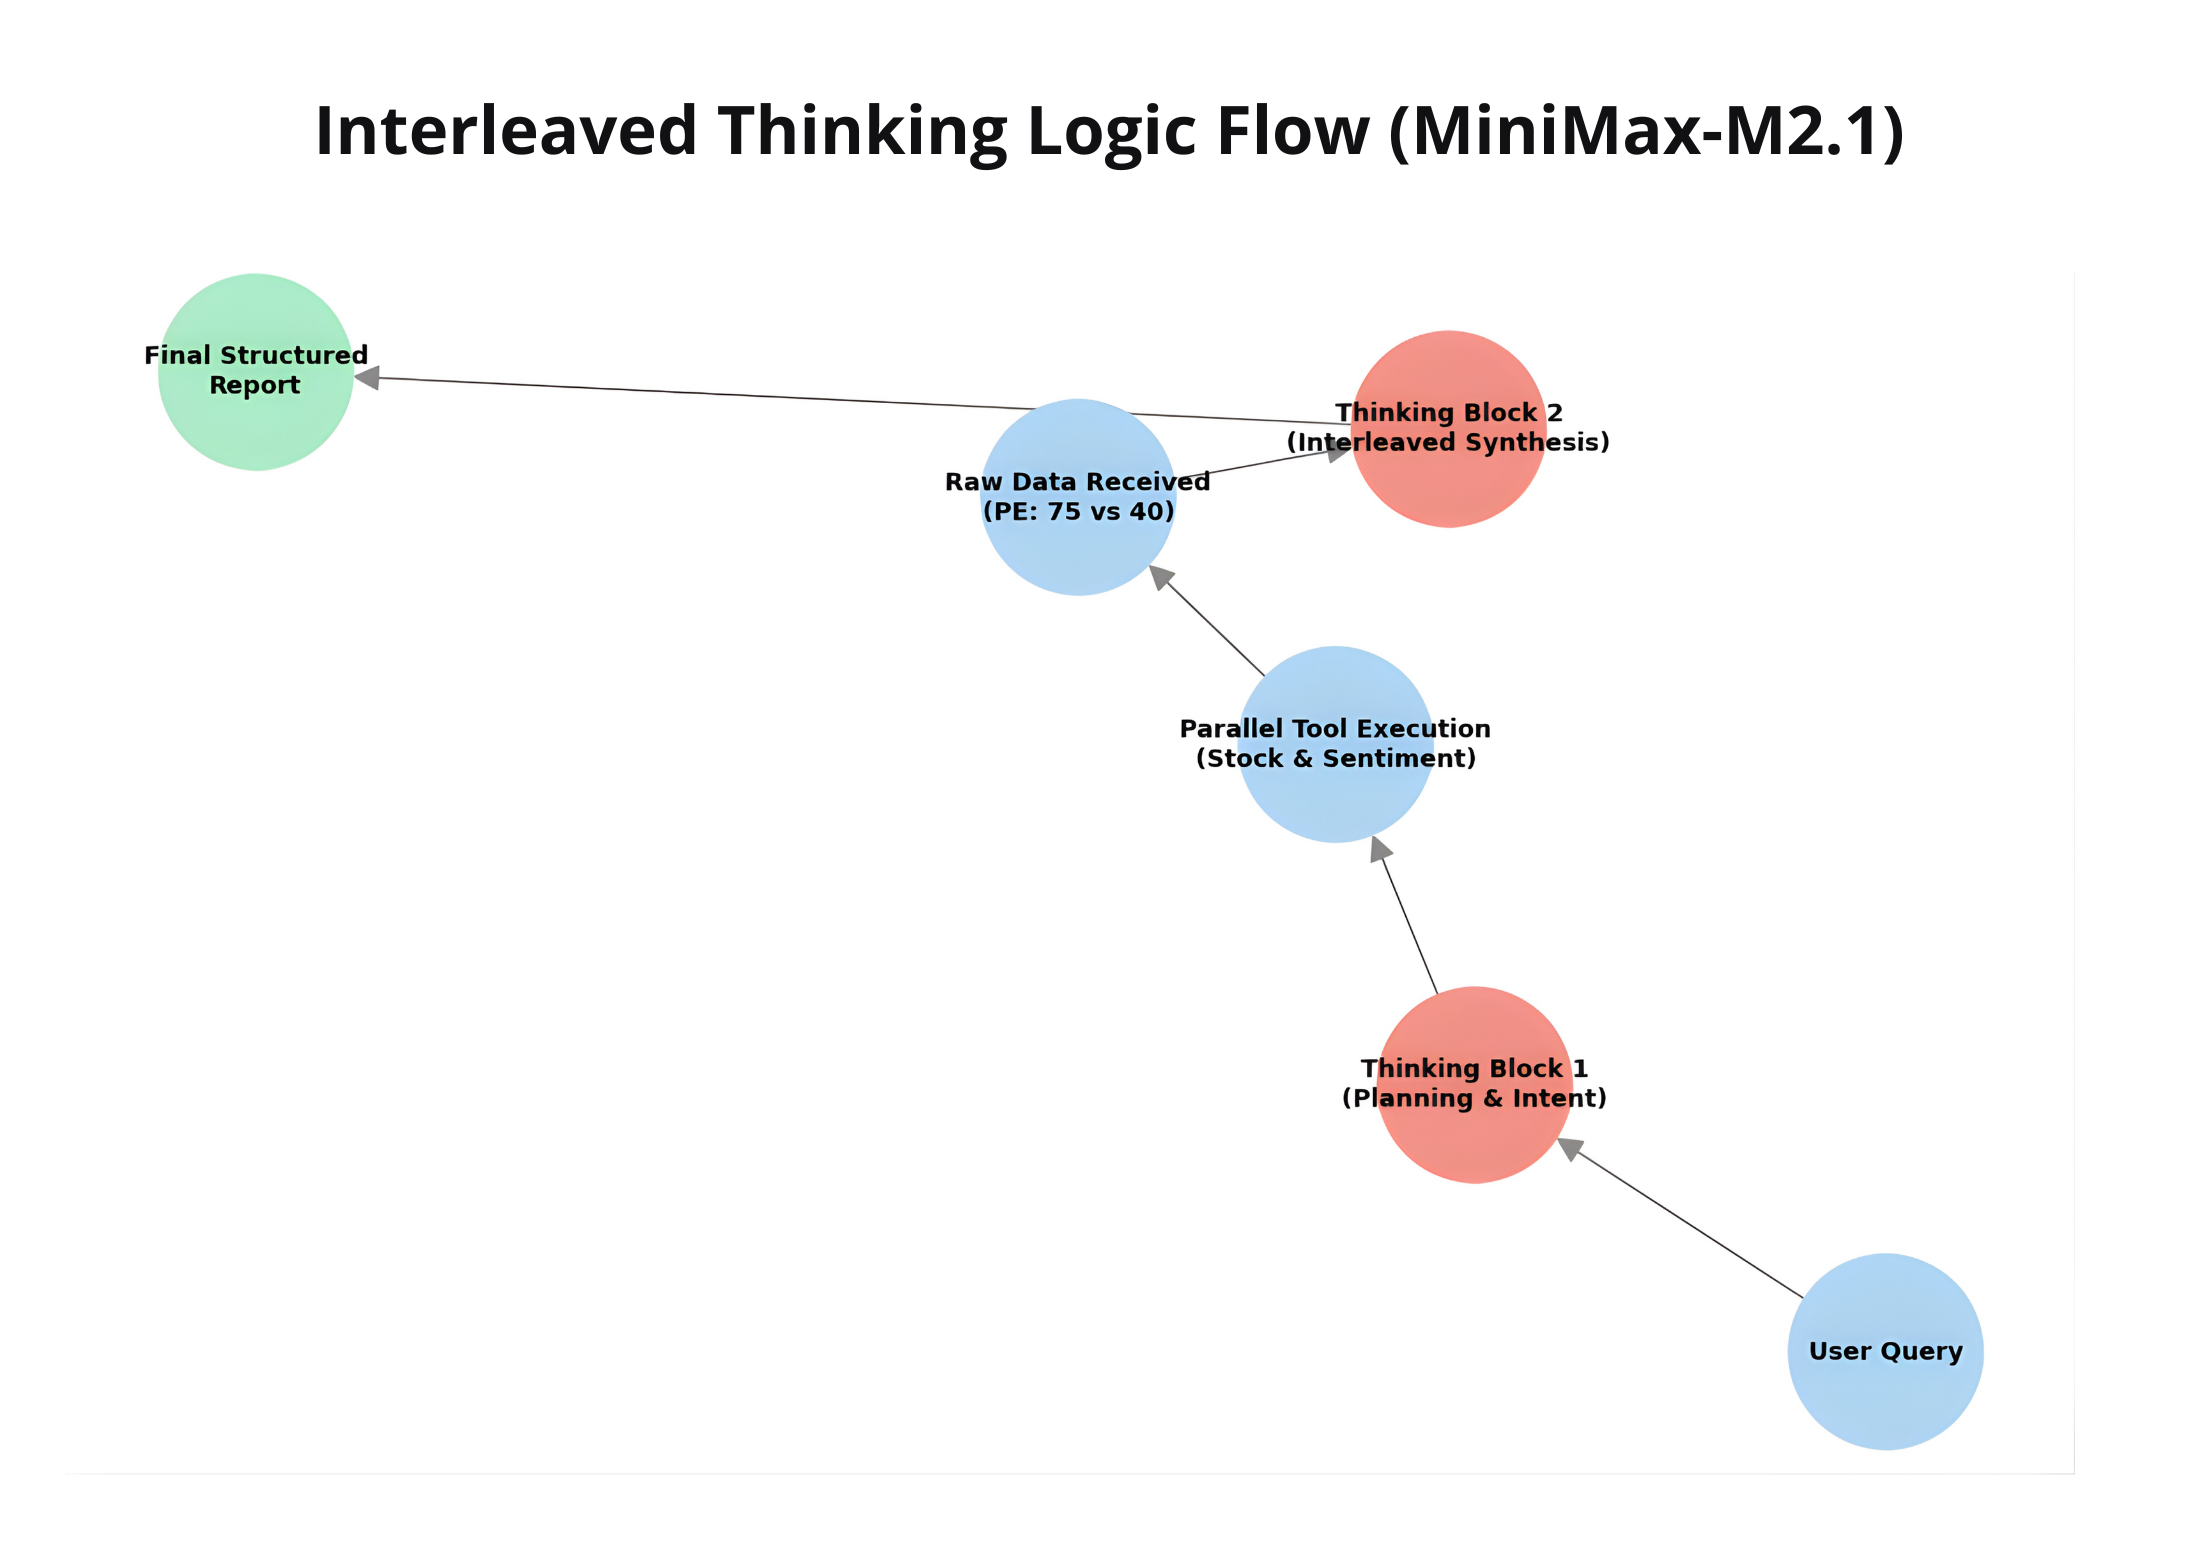

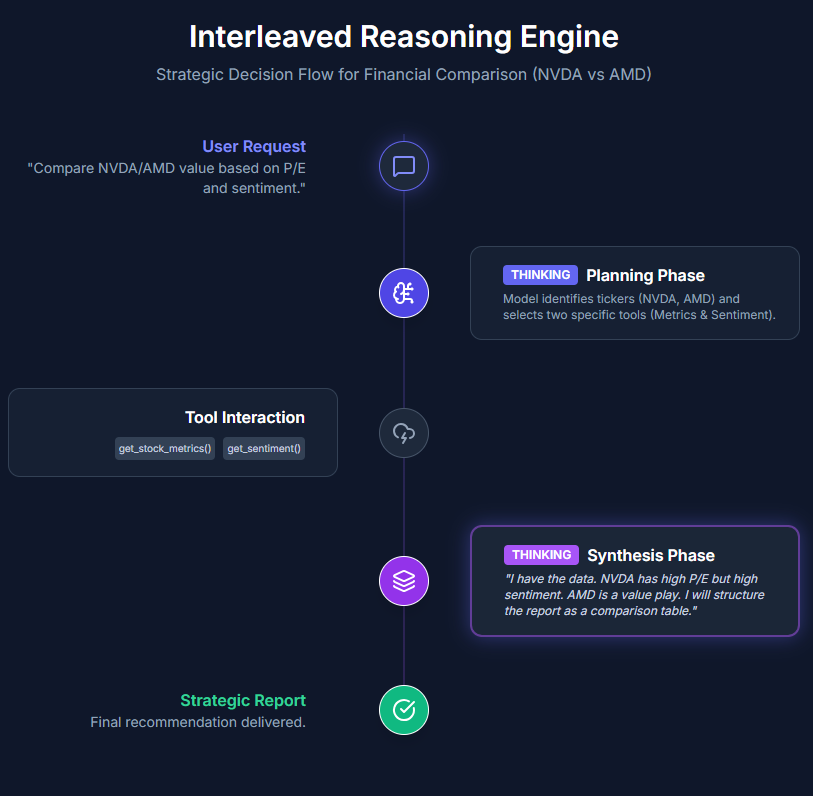

# Comparison with OpenAI’s GPT-5.2
Finally, we compare MiniMax M2.1 with GPT-5.2 using a compact multilingual instruction-following prompt. The task requires the model to identify coffee-related terms from a Spanish passage, translate only those terms into English, remove duplicates, and return the result in a strictly formatted numbered list.

To run this code block, you’ll need an OpenAI API key, which can be generated from the [OpenAI developer dashboard](https://platform.openai.com/settings/organization/api-keys).


In [4]:
os.environ['OPENAI_API_KEY'] = getpass ('Enter OpenAI API Key: ')

Enter OpenAI API Key: ··········


In [9]:
input_text = """
¡Preparar café Cold Brew es un proceso sencillo y refrescante!
Todo lo que necesitas son granos de café molido grueso y agua fría.
Comienza añadiendo el café molido a un recipiente o jarra grande.
Luego, vierte agua fría, asegurándote de que todos los granos de café
estén completamente sumergidos.
Remueve la mezcla suavemente para garantizar una saturación uniforme.
Cubre el recipiente y déjalo en remojo en el refrigerador durante al
menos 12 a 24 horas, dependiendo de la fuerza deseada.
"""

prompt = f"""
The following text is written in Spanish.

Task:
1. Identify all words in the text that are related to coffee or coffee preparation.
2. Translate ONLY those words into English.
3. Remove duplicates (each word should appear only once).
4. Present the result as a numbered list.

Rules:
- Do NOT include explanations.
- Do NOT include non–coffee-related words.
- Do NOT include Spanish words in the final output.

Text:
<{input_text}>
"""

from openai import OpenAI
client = OpenAI()

response = client.responses.create(
    model="gpt-5.2",
    input=prompt
)

print(response.output_text)

1. Coffee  
2. Cold Brew  
3. Beans  
4. Ground coffee  
5. Coarsely ground  
6. Water  
7. Pitcher  
8. Container  
9. Mixture  
10. Steep  
11. Refrigerator


In [14]:
import anthropic

client = anthropic.Anthropic()

message = client.messages.create(
    model="MiniMax-M2.1",
    max_tokens=10000,
    system="You are a helpful assistant.",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]
)

for block in message.content:
    if block.type == "thinking":
        print(f"Thinking:\n{block.thinking}\n")
    elif block.type == "text":
        print(f"Text:\n{block.text}\n")

Thinking:
First, I need to identify all words in the Spanish text that are related to coffee or coffee preparation. The text is about making Cold Brew coffee.

Let me read the text carefully:

"¡Preparar café Cold Brew es un proceso sencillo y refrescante!

Todo lo que necesitas son granos de café molido grueso y agua fría.

Comienza añadiendo el café molido a un recipiente o jarra grande.

Luego, vierte agua fría, asegurándote de que todos los granos de café

estén completamente sumergidos.

Remueve la mezcla suavemente para garantizar una saturación uniforme.

Cubre el recipiente y déjalo en remojo en el refrigerador durante al

menos 12 a 24 horas, dependiendo de la fuerza deseada."

Now, I need to find words related to coffee or its preparation. This includes terms like coffee itself, preparation methods, tools, etc.

List out all words that might be coffee-related:

- "café" – this is Spanish for coffee, so definitely related.

- "Cold Brew" – this is a specific type of coffee pre

When comparing the outputs, MiniMax M2.1 produces a noticeably broader and more granular set of coffee-related terms than GPT-5.2. M2.1 identifies not only core nouns like coffee, beans, and water, but also preparation actions (pour, stir, cover), process-related states (submerged, soak), and contextual attributes (cold, coarse, strength, hours).

This indicates a deeper semantic pass over the text, where the model reasons through the entire preparation workflow rather than extracting only the most obvious keywords.

This difference is also reflected in the reasoning process. M2.1 explicitly analyzes context, resolves edge cases (such as borrowed English terms like Cold Brew), considers duplicates, and deliberates on whether certain adjectives or verbs qualify as coffee-related before finalizing the list. GPT-5.2, by contrast, delivers a shorter and more conservative output focused on high-confidence terms, with less visible reasoning depth.

Together, this highlights M2.1’s stronger instruction adherence and semantic coverage, especially for tasks that require careful filtering, translation, and strict output control.


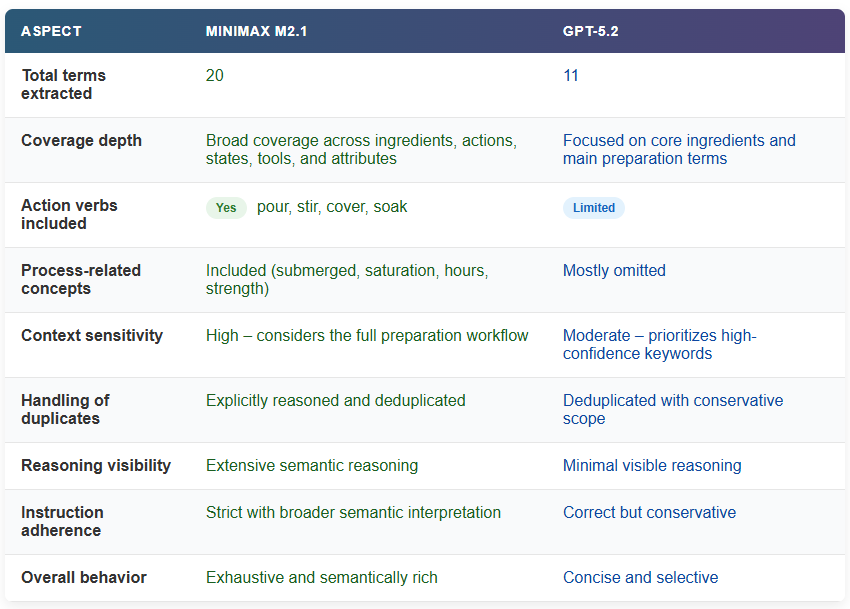